In [76]:
import pickle
import pandas as pd
import numpy as np
data_ws = pd.read_pickle("./data_title_ws_0224.pkl")
data_sentence = pd.read_pickle("./data_title_sentence_0224.pkl")

In [77]:
target_feature = 'claim'
data_ws = data_ws.filter([target_feature + "_vector", 'label'])
data_sentence = data_sentence.filter([target_feature + "_vector", 'label'])

In [78]:
print(data_ws.isnull().any())
print(data_ws.shape)
print(data_sentence.isnull().any())
print(data_sentence.shape)

claim_vector    False
label           False
dtype: bool
(99, 2)
claim_vector    False
label           False
dtype: bool
(99, 2)


In [79]:
data_ws.head()
data_sentence.head()

,claim_vector,label
1,"[[-0.12350344, 0.17572916, -0.09357828, 0.1786...",0
2,"[[-0.27421924, 0.43389776, -0.46236145, -0.219...",0
3,"[[-0.30246344, 0.586126, -0.6084991, -0.267143...",0
4,"[[-0.10293593, 0.51177627, -0.4142877, -0.1428...",0
5,"[[-0.6294708, 0.60767037, -1.162143, -0.005531...",0


In [80]:
max_len = 0
for vec in data_sentence[target_feature + "_vector"]:
    if len(vec) > max_len:
        max_len = len(vec)
max_len

1

In [81]:
max_len = 0
for vec in data_ws[target_feature + "_vector"]:
    if len(vec) > max_len:
        max_len = len(vec)
max_len

52

In [82]:
title = list()
for title_vec in data_ws[target_feature + "_vector"]:
    title_vec = np.vstack(title_vec)
    padding_num = max_len - title_vec.shape[0]
    padding_vec = np.empty(title_vec.shape[1]*padding_num)
    padding_vec.fill(float(0))
    padding_vec = pd.DataFrame(padding_vec.reshape(padding_num,title_vec.shape[1]))
    title_vec = pd.DataFrame(title_vec)
    title_vec = pd.concat([padding_vec, title_vec])
    title.append(title_vec)
title = np.array(title)

In [83]:
from sklearn.model_selection import train_test_split
X_ws_train, X_ws_test, y_ws_train, y_ws_test = train_test_split(title, data_ws['label'], test_size=0.2, random_state=777)
X_sentence_train, X_sentence_test, y_sentence_train, y_sentence_test = train_test_split(data_sentence[target_feature + "_vector"], data_sentence['label'], test_size=0.2, random_state=777)

In [84]:
X_sentence_train = np.vstack(X_sentence_train)
X_sentence_test = np.vstack(X_sentence_test)
y_sentence_train = np.vstack(y_sentence_train)
y_sentence_test = np.vstack(y_sentence_test)

In [85]:
from tensorflow.keras.layers import Input, LSTM, concatenate, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=0, patience=5, min_lr=1e-6, verbose=1)

adam = Adam(lr=0.001, clipvalue=0.5)

input_ws = Input(shape=(X_ws_train.shape[1], X_ws_train.shape[2]))
input_sentence = Input(shape=(1, X_sentence_train.shape[1]))

lstm = LSTM(20, dropout=0.5, recurrent_dropout=0.5)(input_ws)

cnn = Conv1D(filters=24, kernel_size=9, activation='relu')(input_ws)
cnn = MaxPooling1D(pool_size=3)(cnn)
# cnn = Conv1D(filters=128, kernel_size=3, activation='relu')(cnn)
# cnn = MaxPooling1D(pool_size=3)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(5, activation='relu')(cnn)
cnn = Dropout(0.5)(cnn)

dnn = Dense(64, activation='relu')(input_sentence)
dnn = Flatten()(dnn)

concat = concatenate([lstm, dnn]) 
output = Dense(1, activation='sigmoid')(concat)
model = Model(inputs=[input_ws, input_sentence], outputs=output)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 1, 768)       0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 52, 768)      0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 1, 64)        49216       input_34[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 20)           63120       input_33[0][0]                   
__________________________________________________________________________________________________
flatten_14

In [87]:
history = model.fit(x=[X_ws_train,np.expand_dims(X_sentence_train, axis=1)], y=y_ws_train, epochs=500, batch_size=8, validation_split=0.2, verbose=1, callbacks=[es, mc, lr_reducer])

nly with val_accuracy available, skipping.
63/63 [==============================] - 1s 8ms/step - loss: 6.4328e-05 - acc: 1.0000 - val_loss: 1.4389e-04 - val_acc: 1.0000
Epoch 436/500
63/63 [==============================] - 1s 8ms/step - loss: 7.1694e-05 - acc: 1.0000 - val_loss: 1.4385e-04 - val_acc: 1.0000
Epoch 437/500
63/63 [==============================] - 1s 8ms/step - loss: 6.3033e-05 - acc: 1.0000 - val_loss: 1.4382e-04 - val_acc: 1.0000
Epoch 438/500
63/63 [==============================] - 1s 8ms/step - loss: 6.7006e-05 - acc: 1.0000 - val_loss: 1.4378e-04 - val_acc: 1.0000
Epoch 439/500
63/63 [==============================] - 1s 8ms/step - loss: 6.7784e-05 - acc: 1.0000 - val_loss: 1.4375e-04 - val_acc: 1.0000
Epoch 440/500
63/63 [==============================] - 1s 8ms/step - loss: 6.8522e-05 - acc: 1.0000 - val_loss: 1.4371e-04 - val_acc: 1.0000
Epoch 441/500
63/63 [==============================] - 1s 8ms/step - loss: 6.7995e-05 - acc: 1.0000 - val_loss: 1.4368e-04 - 

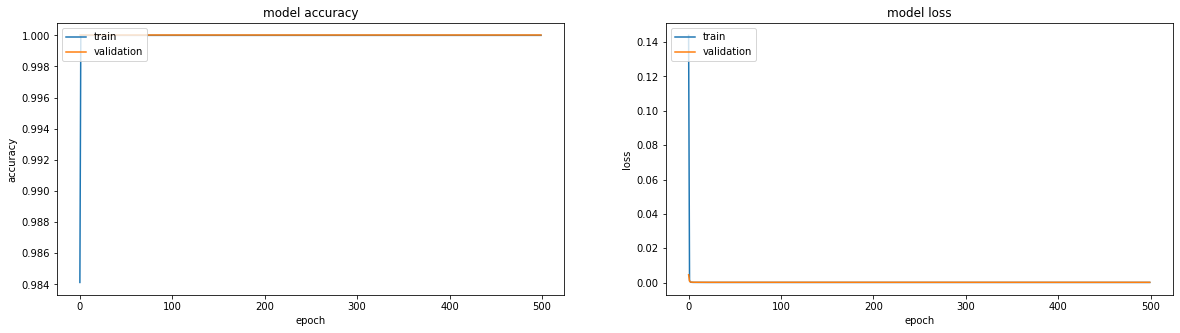

In [89]:
import matplotlib.pyplot as plt
plt.subplots(1,2,figsize=(20,5))
# summarize history for accuracy
ax1 = plt.subplot(121)
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
ax2 = plt.subplot(122)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
plt.show()

In [65]:
best_model = load_model('best_model.h5')
score = best_model.evaluate(x=[X_ws_test,X_sentence_test], y=y_ws_test)
print("Evaluate on test data")
print("test loss, test acc:", score)

30/30 [==============================] - 1s 27ms/step - loss: 0.5258 - accuracy: 0.8105
Evaluate on test data
test loss, test acc: [0.5258210301399231, 0.8104711771011353]
